In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import time

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss


from scipy.io import loadmat  # this is the SciPy module that loads mat-files
from sklearn.feature_selection import SequentialFeatureSelector

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import datetime

In [2]:
start_time = time.time()

In [2]:
def FauxPenalty(genome):
    print('error')
    return 0  

def DecodeNumbersSingular(x,start,step):
    d = len(x)
    b = np.empty(d)
    for j in range(d):
        b[j] = x[j][1:].dot(2**np.arange(x[j].size-1)[::-1]) 
        b[j] = start+ b[j] * step
    return b

class FSGA:

    #///////////ШТРАФНЫЕ ФУНКЦИИ/////////////////////////   


    def PenaltyDynamicRate(self):
        '''Функция динамики коэффициентов штрафных функций'''
        return self.dyn_pen_coeff*self.t+1
    
    def AdaptationRate(self):
        '''Адаптивное изменение '''
        if(len(self.best_res_penalties)<self.adaptive_K):
            return 1
        
        penalty_count = 0
        for i in range(1,self.adaptive_K +1):
            if(self.best_res_penalties[-i]>0.000001):
                penalty_count += 1

        if(penalty_count == self.adaptive_K):
            return self.adaptive_Beta2
        elif(penalty_count == 0):
            return self.adaptive_Beta1
        
        
        return 1
    
    def CalculatePenalty(self):
        #**TODO** - БУДЕТ СЧИТАТЬСЯ ПРИ КЛАССИФИКАЦИИ
        
        adaptive_coeff = self.AdaptationRate()
        dynamic_rate = self.PenaltyDynamicRate()
        penalty_modifier = self.penalty_gamma*dynamic_rate*adaptive_coeff
        
        self.penalties = self.penalties * penalty_modifier



    def UpdatePopulation(self, population):
        self.pop_size = len(population)
        self.population = population
        self.CalculateFitness()



    def TournamentSelection(self, t_size):
        '''Турнирная селекция с параметром - размером турнира'''
        parents = np.empty([self.pop_size, self.gene_length])

        for i in range(self.pop_size):
            tournament_choice = np.random.randint(self.pop_size, size=t_size)
            candidates = self.population[tournament_choice]
            their_fitnesses = self.fitnesses[tournament_choice]
            parents[i] = candidates[np.argmin(their_fitnesses)]

        return parents
    
    def RankingSelection(self, sp=1.7):
        '''Ранговая селекция с параметром рангового коэффициента'''
                
        indeces = np.argsort(-self.fitnesses)
        temp = np.array(range(self.pop_size))
        probabilities = 1/self.pop_size*(sp-2*(sp-1)*(temp)/(self.pop_size-1))
        parents = self.population[np.random.choice(indeces,size=self.pop_size,p=probabilities)]
        
        return parents
    
    def OnePointCrossover (parent1, parent2):
        n = len(parent1)
        crosspoint = np.random.randint(1,n-1)        
        child1 = np.concatenate((parent1[0:crosspoint],parent2[crosspoint:]))
        child2 = np.concatenate((parent2[0:crosspoint],parent1[crosspoint:]))

        return child1, child2
    
    def CalculateFitness(self):
        self.Fitness()
        
        if(self.penalty_gamma != 0):
            self.CalculatePenalty()
            #print(f'pre: {np.min(self.fitnesses)}',end=' ')
            self.best_res_penalties.append(self.penalties[np.argmin(self.fitnesses)])
            self.fitnesses = self.fitnesses + self.penalties
            #print(f'post: {np.min(self.fitnesses)}')

    def DEBUG_BEST_FITNESS(self):
        return np.min(self.fitnesses)

    def ReturnBest(self):
        return self.population[np.argmin(self.fitnesses)]
    
    def MutatePopulation(self,children):
        for i in range(0,self.pop_size):
            for j in range(0,self.gene_length):
                if(random.uniform(0,1)<self.mut_rate):
                    children[i,j] = 1 - children[i,j]

    
    def GenerateChildren(self,parents):
        '''Генерация потомков'''
        # 
        children = np.empty([self.pop_size, self.gene_length],dtype=np.int32)
        for i in range(int(self.pop_size/2)):
            children[i*2], children[i*2+1] = self.Crossing(parents[i*2],parents[i*2+1])
        if(self.pop_size%2 == 1):
            children[-1] = parents[-1]


        self.MutatePopulation(children)
        return children.reshape(self.pop_size, self.gene_length)               

    def GenerateNewPopulation(self):
        '''Генерация новое поколение'''

        #Добавляет лучшее решение в следующее поколение
        new_pop = self.GenerateChildren(parents=self.Selection(self, self.select_param))
        #new_pop = np.append(new_pop, [self.ReturnBest()],axis=0)
        self.UpdatePopulation(new_pop)

    def Fit(self):
        for i in range(self.max_epochs):
            self.t += 1
            self.GenerateNewPopulation()
        
        return np.min(self.fitnesses), self.ReturnBest()


    def __init__(self, max_epochs, population, select_param, Selection, Crossing, mut_rate, input_dataset, goal_accuracy, penalty_coeffs=[1,1,3,2]):
        self.max_epochs = max_epochs
        self.select_param = select_param
        self.Selection = Selection

        self.Crossing = Crossing
        self.true_mut_rate = mut_rate
        
        self.gene_length = len(population[0])
        self.mut_rate = mut_rate/self.gene_length

        self.penalty_gamma = penalty_coeffs[0]
        self.t = 0

        self.best_res_penalties = []
        self.dyn_pen_coeff = penalty_coeffs[1]
        self.adaptive_K = penalty_coeffs[2]
        '''Окно адаптации'''
        self.adaptive_Beta1 = 1/penalty_coeffs[3]
        '''Адаптивный коэффициент понижения штрафа'''
        self.adaptive_Beta2 = penalty_coeffs[3]
        '''Адаптивный коэффициент повышения штрафа'''

        #Пошла классификация

        self.true_data = input_dataset
        self.goal_accuracy = goal_accuracy
        
        self.var_names = self.true_data.columns[:-1]
        self.class_name = self.true_data.columns[-1]

        self.y = self.true_data[self.class_name]

        self.Fitness = self.PerformClassification

        self.UpdatePopulation(population)
   
    def SetMasks(self):
        self.masks = []
        for j in range(self.pop_size):
            single_mask = []
            for i in range(self.gene_length):
                if(self.population[j][i] == 1):
                    single_mask.append(self.var_names[i])
            self.masks.append(single_mask)

    
    def SetDatasets(self):
        self.datasets = []
        for mask in self.masks:
            self.datasets.append(self.true_data[mask])

    def PerformClassification(self):
        self.SetMasks()
        self.SetDatasets()
        
        self.fitnesses = []
        self.penalties = []
        for X in self.datasets:
            if(len(X.columns) == 0):
                # Есть случаи, когда алгоритм генерирует 0 признаков. Это сильно наказывается
                fitness = 10000
                penalty = 100
            else:          
                X_train, X_test, y_train, y_test = train_test_split(X,self.y,test_size=0.3)

                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_test = scaler.transform(X_test)

                knn = KNeighborsClassifier(n_neighbors=5)
                knn.fit(X_train, y_train)


                predicted_probabilities = cross_val_predict(knn, X, self.y, cv=5, method='predict_proba')
                
                fitness = log_loss(self.y, predicted_probabilities)
                y_pred = knn.predict(X_test)
                knn_accuracy = accuracy_score(y_test, y_pred)

                penalty = np.max([0,(self.goal_accuracy-knn_accuracy)])

            self.penalties.append(penalty)
            self.fitnesses.append(fitness)
        
        self.fitnesses = np.array(self.fitnesses)       
        self.penalties = np.array(self.penalties)

def InitializeStartingPopulation(n, pop_size):
    return np.random.randint(2,size=(pop_size,n))


In [4]:
x = np.random.randint(2,size=(50))
print(np.shape(x))

(50,)


In [3]:
def InitializeFeatSelectPopulation(n, pop_size):
    x = np.random.randint(2,size=(pop_size,n))
    return x

In [94]:
def AssembleDataset(tv, nv, df_len):

    mask_weights = np.ones(tv)

    sep_line = np.sum(mask_weights)*5

    raw_data = np.empty((0,tv+nv))
    true_y = []
    t = 1
    for i in range(df_len):
        true_data = np.random.uniform(0,10,(tv))
        if(np.dot(true_data,mask_weights)>sep_line):
            true_y.append(1)
            t+=1
        else:
            true_y.append(0)
        noise_data = np.random.uniform(-1,1,(nv))
        raw_data = np.vstack((raw_data, np.concatenate((true_data,noise_data))))

    column_names = [f'var{i+1}' for i in range(0,tv+nv)]
    true_vars = column_names[0:tv]
    meaningful_vars = column_names[0:5]
    fake_vars = column_names[tv:]
    new_column = {'class':true_y}

    df = pd.DataFrame(raw_data,columns=column_names)
    df = df.assign(**new_column)
    return df

In [8]:
the_dataset = pd.read_csv('data.csv')
the_dataset.pop(the_dataset.columns[0])

feature_list = the_dataset.columns[:-1]
print(feature_list)
feat_length = len(feature_list)

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='object')


Результаты для ЦФ - точность

In [82]:
test_size = 3
test_results = np.zeros(test_size)
accur_list = [0.8]
ds_size = 1000
data = []


GAMMAS = [0]
DYNAMIC_RATES = [1]
ADAPTIVE_COEFFS = [2]
Ks = [3]

resulting_features = []


true_features = np.array([1,1,1,1,0,0,0,0,0,0])

for K in Ks:
    for gamma in GAMMAS:
        for dyn_rate in DYNAMIC_RATES:
            for ad_coeff in ADAPTIVE_COEFFS:
                for goal_acc in accur_list:
                    for i in range(test_size):
                        genetic_object = FSGA(Crossing=FSGA.OnePointCrossover,
                                            max_epochs=20,
                                            mut_rate=1,
                                            population=InitializeFeatSelectPopulation(pop_size=50,n=feat_length),
                                            Selection=FSGA.TournamentSelection,
                                            input_dataset=the_dataset,
                                            goal_accuracy=goal_acc,
                                            select_param=4,
                                            penalty_coeffs=[gamma,dyn_rate,K,ad_coeff])
                        test_results[i], best_result =genetic_object.Fit()
                        resulting_features.append(best_result)
                    the_bestest_result = resulting_features[np.argmin(test_results)]
                    errors = np.sum(np.abs(the_bestest_result-true_features))
                    data.append([goal_acc,gamma, dyn_rate, ad_coeff, the_bestest_result,errors,np.average(test_results),np.std(test_results), np.min(test_results),np.median(test_results),np.max(test_results)])
                    print('*', end= ' ')
df = pd.DataFrame(data, columns=['Целевая точность','Гамма','д','а', 'Признаки', 'Расхождение','МО', 'СКО', 'мин', 'медиана', 'макс'])
df

* 

,Целевая точность,Гамма,д,а,Признаки,Расхождение,МО,СКО,мин,медиана,макс
0,0.8,0,1,2,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0]",1,-1.0,0.0,-1.0,-1.0,-1.0


Результаты для ЦФ - кросс-энтропия

In [ ]:
test_size = 1
test_results = np.zeros(test_size)
accur_list = [0.8]
ds_size = 1000
data = []


GAMMAS = [1]
DYNAMIC_RATES = [1]
ADAPTIVE_COEFFS = [2]
Ks = [3]

resulting_features = []


true_features = np.array([1,1,1,1,0,0,0,0,0,0])

for K in Ks:
    for gamma in GAMMAS:
        for dyn_rate in DYNAMIC_RATES:
            for ad_coeff in ADAPTIVE_COEFFS:
                for goal_acc in accur_list:
                    for i in range(test_size):
                        genetic_object = FSGA(Crossing=FSGA.OnePointCrossover,
                                            max_epochs=20,
                                            mut_rate=1,
                                            population=InitializeFeatSelectPopulation(pop_size=50,n=feat_length),
                                            Selection=FSGA.TournamentSelection,
                                            input_dataset=the_dataset,
                                            goal_accuracy=goal_acc,
                                            select_param=4,
                                            penalty_coeffs=[gamma,dyn_rate,K,ad_coeff])
                        test_results[i], best_result =genetic_object.Fit()
                        resulting_features.append(best_result)
                    the_bestest_result = resulting_features[np.argmin(test_results)]
                    errors = np.sum(np.abs(the_bestest_result-true_features))
                    data.append([goal_acc,gamma, dyn_rate, ad_coeff, the_bestest_result,errors,np.average(test_results),np.std(test_results), np.min(test_results),np.median(test_results),np.max(test_results)])
                    print('*', end= ' ')
df = pd.DataFrame(data, columns=['Целевая точность','Гамма','д','а', 'Признаки', 'Расхождение','МО', 'СКО', 'мин', 'медиана', 'макс'])
df

* 

,Целевая точность,Гамма,д,а,Признаки,Расхождение,МО,СКО,мин,медиана,макс
0,0.8,0,1,2,"[1, 1, 1, 1, 0, 1, 1, 1, 0, 1]",4,0.000163,0.0,0.000163,0.000163,0.000163


Со штрафами

In [91]:
test_size = 1
test_results = np.zeros(test_size)
accur_list = [0.8,0.9,0.95]
ds_size = 1000
data = []


GAMMAS = [3]
DYNAMIC_RATES = [1]
ADAPTIVE_COEFFS = [2]
Ks = [3]

resulting_features = []


true_features = np.array([1,1,1,1,0,0,0,0,0,0])

for K in Ks:
    for gamma in GAMMAS:
        for dyn_rate in DYNAMIC_RATES:
            for ad_coeff in ADAPTIVE_COEFFS:
                for goal_acc in accur_list:
                    for i in range(test_size):
                        genetic_object = FSGA(Crossing=FSGA.OnePointCrossover,
                                            max_epochs=20,
                                            mut_rate=1,
                                            population=InitializeFeatSelectPopulation(pop_size=50,n=feat_length),
                                            Selection=FSGA.TournamentSelection,
                                            input_dataset=the_dataset,
                                            goal_accuracy=goal_acc,
                                            select_param=4,
                                            penalty_coeffs=[gamma,dyn_rate,K,ad_coeff])
                        test_results[i], best_result =genetic_object.Fit()
                        resulting_features.append(best_result)
                    the_bestest_result = resulting_features[np.argmin(test_results)]
                    errors = np.sum(np.abs(the_bestest_result-true_features))
                    data.append([goal_acc,gamma, dyn_rate, ad_coeff, the_bestest_result,errors,np.average(test_results),np.std(test_results), np.min(test_results),np.median(test_results),np.max(test_results)])
                    print('*', end= ' ')
df = pd.DataFrame(data, columns=['Целевая точность','Гамма','д','а', 'Признаки', 'Расхождение','МО', 'СКО', 'мин', 'медиана', 'макс'])
df

* * * 

,Целевая точность,Гамма,д,а,Признаки,Расхождение,МО,СКО,мин,медиана,макс
0,0.80,3,1,2,"[1, 1, 1, 1, 0, 1, 1, 0, 0, 1]",3,0.000163,0.0,0.000163,0.000163,0.000163
1,0.90,3,1,2,"[1, 1, 1, 1, 0, 1, 1, 0, 0, 1]",3,0.000163,0.0,0.000163,0.000163,0.000163
2,0.95,3,1,2,"[1, 1, 1, 1, 0, 1, 1, 0, 0, 1]",3,0.000163,0.0,0.000163,0.000163,0.000163


In [68]:
np.ones(10)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [63]:
test_size = 10
test_results = np.zeros(test_size)
accur_list = [0.8]
ds_size = 1000
data = []


GAMMAS = [0.75 ,1, 1.25, 1.5, 1.75, 2, 2.25, 2.5]
DYNAMIC_RATES = [1]
ADAPTIVE_COEFFS = [2]
Ks = [3]

resulting_features = []

true_features = np.array([1,1,1,1,0,0,0,0,0,0])

for K in Ks:
    for gamma in GAMMAS:
        for dyn_rate in DYNAMIC_RATES:
            for ad_coeff in ADAPTIVE_COEFFS:
                for goal_acc in accur_list:
                    for i in range(test_size):
                        genetic_object = FSGA(Crossing=FSGA.OnePointCrossover,
                                            max_epochs=10,
                                            mut_rate=1,
                                            population=InitializeFeatSelectPopulation(pop_size=20,n=feat_length),
                                            Selection=FSGA.RankingSelection,
                                            input_dataset=the_dataset,
                                            goal_accuracy=goal_acc,
                                            select_param=1.9,
                                            penalty_coeffs=[gamma,dyn_rate,K,ad_coeff])
                        test_results[i], best_result =genetic_object.Fit()
                        resulting_features.append(best_result)
                    the_bestest_result = resulting_features[np.argmin(test_results)]
                    errors = np.sum(np.abs(the_bestest_result-true_features))
                    data.append([goal_acc,gamma, dyn_rate, ad_coeff, the_bestest_result,errors,np.average(test_results),np.std(test_results), np.min(test_results),np.median(test_results),np.max(test_results)])
                    print('*', end= ' ')
df = pd.DataFrame(data, columns=['Целевая точность','Гамма','д','а', 'Признаки', 'Расхождение','МО', 'СКО', 'мин', 'медиана', 'макс'])
df

* * * * * * * * 

,Целевая точность,Гамма,д,а,Признаки,Расхождение,МО,СКО,мин,медиана,макс
0,0.8,0.75,1,2,"[1, 1, 1, 1, 1, 0, 1, 1, 1, 0]",4,0.453360,0.346846,0.000325,0.444010,0.942266
1,0.8,1.00,1,2,"[1, 1, 0, 0, 0, 1, 1, 1, 1, 1]",7,0.547526,0.423584,0.006544,0.468021,1.185978
2,0.8,1.25,1,2,"[1, 1, 1, 0, 1, 1, 1, 0, 0, 1]",5,0.839133,0.906191,0.006887,0.508388,3.040045
3,0.8,1.50,1,2,"[1, 0, 0, 1, 0, 1, 1, 1, 0, 1]",6,0.664169,0.598114,0.000325,0.758674,1.820268
4,0.8,1.75,1,2,"[0, 1, 1, 0, 1, 1, 1, 1, 1, 0]",7,0.498039,0.328652,0.000488,0.570196,0.932878
5,0.8,2.00,1,2,"[1, 0, 1, 1, 1, 0, 1, 1, 0, 1]",5,0.405304,0.393739,0.146839,0.228141,1.391097
6,0.8,2.25,1,2,"[1, 0, 0, 1, 1, 0, 0, 0, 0, 0]",3,0.595534,0.639264,0.005847,0.324028,1.843069
7,0.8,2.50,1,2,"[1, 1, 1, 0, 1, 1, 1, 0, 0, 1]",5,0.765886,0.359567,0.147860,0.814082,1.380543


In [11]:
df = pd.DataFrame(data, columns=['Гамма','д','а', 'Количество признаков','МО', 'СКО', 'мин', 'медиана', 'макс'])
df

,Гамма,д,а,Количество признаков,МО,СКО,мин,медиана,макс
0,0.5,1,1.5,8,0.062997,0.084272,0.000325,0.006544,0.182121
1,0.5,1,2.0,5,0.288304,0.231784,0.006056,0.285074,0.573782
2,0.5,1,5.0,5,2.389191,1.357884,1.272425,1.594650,4.300497


In [12]:
the_bestest_result

array([1, 1, 0, 1, 1, 0, 0, 0, 0, 1], dtype=int32)

In [ ]:

start_time = time.time()


scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(the_dataset[feature_list])

y = the_dataset['class']


knn = KNeighborsClassifier(n_neighbors=5)
sfs = SequentialFeatureSelector(knn, n_features_to_select=1)
sfs.fit(data_rescaled, y)

X_train, X_test, y_train, y_test = train_test_split(sfs.transform(data_rescaled),y,test_size=0.25)
knn.fit(X_train, y_train)

predicted_probabilities = cross_val_predict(knn, data_rescaled, y, cv=5, method='predict_proba')

fitness = log_loss(y, predicted_probabilities)
y_pred = knn.predict(X_test)
knn_accuracy = accuracy_score(y_test, y_pred)

print(f'variables: {4}')
print(f'time: {str(datetime.timedelta(seconds=time.time() - start_time))}')
print(f'log loss: {fitness}')
print(f'accuracy: {knn_accuracy}\n')
print(f'features: {sfs.get_support()}')

variables: 4
time: 0:00:01.284095
log loss: 0.5722905617547164
accuracy: 0.8279883381924198

features: [ True False False False False False False False False False]


In [ ]:
test_size = 1
test_results = np.zeros(test_size)
accur_list = [0.75,0.8, 0.9, 0.95,0.99]
tv = 10
nv = 20
ds_size = 1000
data = []

true_features_hypercube = np.concat((np.ones(tv), np.zeros(nv)))

resulting_features = []
for goal_acc in accur_list:
    dataset = AssembleDataset(tv,nv,ds_size)
    gene_length = tv + nv
    for i in range(test_size):
        genetic_object = FSGA(Crossing=FSGA.OnePointCrossover,
                            max_epochs=20,
                            mut_rate=1,
                            population=InitializeFeatSelectPopulation(pop_size=50,n=gene_length),
                            Selection=FSGA.TournamentSelection,
                            input_dataset=dataset,
                            goal_accuracy=goal_acc,
                            select_param=3)
        test_results[i], best_result =genetic_object.Fit()
        resulting_features.append(best_result)
    the_bestest_result = resulting_features[np.argmin(test_results)]
    errors = np.sum(np.abs(the_bestest_result-true_features_hypercube))
    data.append([goal_acc, np.sum(the_bestest_result),errors,np.average(test_results),np.std(test_results), np.min(test_results),np.median(test_results),np.max(test_results)])
    print('*', end = ' ')
df = pd.DataFrame(data, columns=['Целевая точность', 'Количество признаков','Расхождения','МО', 'СКО', 'мин', 'медиана', 'макс'])
df

* 

,Целевая точность,Количество признаков,Расхождения,МО,СКО,мин,медиана,макс
0,0.95,14,4.0,3.708781,0.0,3.708781,3.708781,3.708781


In [ ]:
mat = loadmat('basehock.mat')  # load mat-file

basehock_df = pd.DataFrame(np.hstack((mat['X'], mat['Y'])))

varnames = basehock_df.columns
varnames = list(map(str,varnames))
basehock_df.columns = varnames
varnames = varnames[:-1]
basehock_df = basehock_df.rename(columns={'4862':'class'})

In [ ]:
X = basehock_df[varnames]
y = basehock_df['class']

test_results = [0]
n_neighbors = range(20)
for i in range(1,20):
    knn_accuracy = []
    for j in range(200):
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(X_train, y_train)

        y_pred = knn.predict(X_test)
        knn_accuracy.append(accuracy_score(y_test, y_pred))
    test_results.append(np.average(knn_accuracy))


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [ ]:
# assuming df is your dataframe
pd.set_option('display.max_columns', None)
basehock_df.describe(include='all')

0            1            2            3            4  \
count  1993.000000  1993.000000  1993.000000  1993.000000  1993.000000   
mean      0.003512     0.002509     0.005519     0.006523     0.006021   
std       0.059175     0.050037     0.080595     0.086531     0.077381   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     2.000000     2.000000     1.000000   

                 5            6            7            8            9  \
count  1993.000000  1993.000000  1993.000000  1993.000000  1993.000000   
mean      0.005018     0.003512     0.004014     0.010035     0.017060   
std       0.100075     0.067125     0.063245     0.104611     0.129526   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       3.000000     2.000000     1.000000     2.000000     1.000000   

                10           11           12           13           14  \
count  1993.000000  1993.000000  1993.000000  1993.000000  1993.000000   
mean      0.032112     0.021074     0.009533     0.010035     0.024084   
std       0.181947     0.157023     0.097197     0.113804     0.171872   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       2.000000     2.000000     1.000000     2.000000     2.000000   

                15           16           17           18           19  \
count  1993.000000  1993.000000  1993.000000  1993.000000  1993.000000   
mean      0.004014     0.040642     0.024084     0.012544     0.021576   
std       0.070739     0.207427     0.168926     0.115744     0.148743   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       2.000000     2.000000     3.000000     2.000000     2.000000   

                20           21           22           23           24  \
count  1993.000000  1993.000000  1993.000000  1993.000000  1993.000000   
mean      0.006021     0.003512     0.012544     0.011540     0.002509   
std       0.077381     0.067125     0.115744     0.120104     0.050037   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     2.000000     2.000000     2.000000     1.000000   

                25           26           27           28           29  \
count  1993.000000  1993.000000  1993.000000  1993.000000  1993.000000   
mean      0.002509     0.065730     0.006021     0.004014     0.004516   
std       0.050037     0.404784     0.094868     0.063245     0.092270   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     7.000000     3.000000     1.000000     2.000000   

               

In [ ]:
# to reset this
pd.reset_option('max_columns')

best n: 0


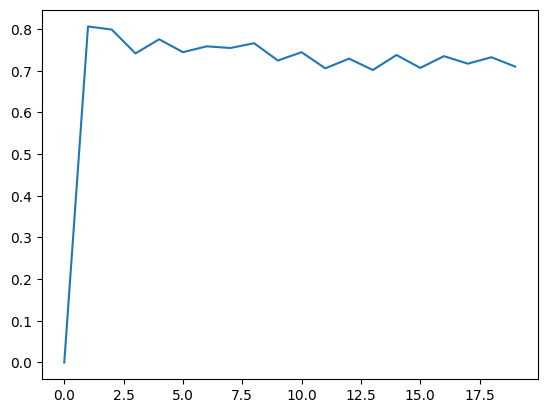

In [ ]:
plt.plot(n_neighbors,test_results)
print(f'best n: {n_neighbors[np.argmax(test_results[2:])]}')

In [ ]:

def Separator(data, tv):
    class_value = 0
    a = 1/tv
    for i in range(0,tv-1):
        class_value += data[i]*a
    class_value -= data[tv-1]
    if class_value >0:
        return 1
    else:
        return 0

In [ ]:
def AssembleDataset(tv, nv, df_len):

    raw_data = np.empty((0,tv+nv))


    for i in range(df_len):
        true_data = np.random.uniform(0,10,(tv))
        noise_data = np.random.uniform(0,1,(nv))
        raw_data = np.vstack((raw_data, np.concatenate((true_data,noise_data))))


    true_y = np.zeros(df_len)
    for i in range(df_len):
        true_y[i] = Separator(raw_data[i], tv)


    column_names = [f'var{i+1}' for i in range(0,tv+nv)]

    new_column = {'classes':true_y}

    raw_df = pd.DataFrame(raw_data,columns=column_names)
    raw_df = raw_df.assign(**new_column)
    return raw_df

In [ ]:
tv = 10
nv = 2000
df_len = 200
mask_weights = [20,10,5,1,1,0.7,0.2,0.1,0.05,0.001]

rng = range(0,10)
sep_line = np.sum(mask_weights)*5

raw_data = np.empty((0,tv+nv))
true_y = []
t = 1
for i in range(df_len):
    true_data = np.random.uniform(0,10,(tv))
    if(np.dot(true_data,mask_weights)>sep_line):
        true_y.append(1)
        t+=1
    else:
        true_y.append(0)
    noise_data = np.random.uniform(0,1,(nv))
    raw_data = np.vstack((raw_data, np.concatenate((true_data,noise_data))))
print(t)

107


In [ ]:
test_size = 5
test_results = np.zeros(test_size)
accur_list = [0.85]
data = []

resulting_features = []
for goal_acc in accur_list:
    for i in range(test_size):
        genetic_object = FSGA(Crossing=FSGA.OnePointCrossover,
                            max_epochs=10,
                            mut_rate=2,
                            population=InitializeFeatSelectPopulation(pop_size=20,n=gene_length),
                            Selection=FSGA.RankingSelection,
                            input_dataset=basehock_df,
                            goal_accuracy=goal_acc,
                            select_param=1.9)
        test_results[i], best_result =genetic_object.Fit()
        resulting_features.append(best_result)
    the_bestest_result = resulting_features[np.argmin(test_results)]
    data.append([goal_acc, np.sum(the_bestest_result),np.average(test_results),np.std(test_results), np.min(test_results),np.median(test_results),np.max(test_results)])
    print('*', end = ' ')
df = pd.DataFrame(data, columns=['Целевая точность', 'Количество признаков','МО', 'СКО', 'мин', 'медиана', 'макс'])
df

In [ ]:

scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(data)
pca = PCA(n_components= 0.99)
pca.fit(data_rescaled)
reduced = pca.transform(data_rescaled)
y = basehock_df['class']

X_train, X_test, y_train, y_test = train_test_split(reduced,y,test_size=0.2)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)


predicted_probabilities = cross_val_predict(knn, reduced, y, cv=5, method='predict_proba')

fitness = log_loss(y, predicted_probabilities)
y_pred = knn.predict(X_test)
knn_accuracy = accuracy_score(y_test, y_pred)

print(f'log loss: {fitness}')
print(f'accuracy: {knn_accuracy}')
print (pca.explained_variance_ratio_.sum())

log loss: 3.7529753866500855
accuracy: 0.5087719298245614


In [ ]:
masks = []
glen = len(the_bestest_result)
for i in range(glen):
    if(the_bestest_result[i] == 1):
        masks.append(varnames[i])


best_result_data = basehock_df[masks]

X_train, X_test, y_train, y_test = train_test_split(best_result_data,y,test_size=0.2)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)


predicted_probabilities = cross_val_predict(knn, best_result_data, y, cv=5, method='predict_proba')

fitness = log_loss(y, predicted_probabilities)
y_pred = knn.predict(X_test)
knn_accuracy = accuracy_score(y_test, y_pred)

print(f'log loss: {fitness}')
print(f'accuracy: {knn_accuracy}')

log loss: 0.5511788515243019
accuracy: 0.7819548872180451


In [ ]:
test_size = 5
test_results = np.zeros(test_size)
accur_list = [0.85]
data = []

resulting_features = []
for goal_acc in accur_list:
    for i in range(test_size):
        genetic_object = FSGA(Crossing=FSGA.OnePointCrossover,
                            max_epochs=10,
                            mut_rate=2,
                            population=InitializeFeatSelectPopulation(pop_size=20,n=gene_length),
                            Selection=FSGA.RankingSelection,
                            input_dataset=basehock_df,
                            goal_accuracy=goal_acc,
                            select_param=1.9)
        test_results[i], best_result =genetic_object.Fit()
        resulting_features.append(best_result)
    the_bestest_result = resulting_features[np.argmin(test_results)]
    data.append([goal_acc, np.sum(the_bestest_result),np.average(test_results),np.std(test_results), np.min(test_results),np.median(test_results),np.max(test_results)])
    print('*', end = ' ')
df = pd.DataFrame(data, columns=['Целевая точность', 'Количество признаков','МО', 'СКО', 'мин', 'медиана', 'макс'])
df

In [ ]:

mat = loadmat('basehock.mat')  # load mat-file

basehock_df = pd.DataFrame(np.hstack((mat['X'], mat['Y'])))

varnames = basehock_df.columns
varnames = list(map(str,varnames))
varnames[-1] = 'class'
basehock_df.columns = varnames


varnames = varnames[:-1]

scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(basehock_df[varnames])

y = basehock_df['class']


knn = KNeighborsClassifier(n_neighbors=5)
sfs = SequentialFeatureSelector(knn, n_features_to_select=45)
sfs.fit(data_rescaled, y)

X_train, X_test, y_train, y_test = train_test_split(sfs.transform(data_rescaled),y,test_size=0.25)
knn.fit(X_train, y_train)

predicted_probabilities = cross_val_predict(knn, data_rescaled, y, cv=5, method='predict_proba')

fitness = log_loss(y, predicted_probabilities)
y_pred = knn.predict(X_test)
knn_accuracy = accuracy_score(y_test, y_pred)

print(f'log loss: {fitness}')
print(f'accuracy: {knn_accuracy}')


In [ ]:

mat = loadmat('basehock.mat')  # load mat-file

basehock_df = pd.DataFrame(np.hstack((mat['X'], mat['Y'])))

varnames = basehock_df.columns
varnames = list(map(str,varnames))
varnames[-1] = 'class'
basehock_df.columns = varnames
varnames = varnames[:-1]

In [ ]:

start_time = time.time()



scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(basehock_df[varnames])

y = basehock_df['class']


knn = KNeighborsClassifier(n_neighbors=5)
sfs = SequentialFeatureSelector(knn, n_features_to_select=1)
sfs.fit(data_rescaled, y)

sfs_data = sfs.transform(data_rescaled)
X_train, X_test, y_train, y_test = train_test_split(sfs_data,y,test_size=0.25)
knn.fit(X_train, y_train)

predicted_probabilities = cross_val_predict(knn, sfs_data, y, cv=5, method='predict_proba')

fitness = log_loss(y, predicted_probabilities)
y_pred = knn.predict(X_test)
knn_accuracy = accuracy_score(y_test, y_pred)

print(f'variables: {4}')
print(f'time: {str(datetime.timedelta(seconds=time.time() - start_time))}')
print(f'log loss: {fitness}')
print(f'accuracy: {knn_accuracy}\n')

variables: 4
time: 0:12:32.315479
log loss: 13.31770543809484
accuracy: 0.627254509018036



In [ ]:
np.shape(X_test)

(499, 1)

In [ ]:

fitness = log_loss(y, predicted_probabilities)
y_pred = knn.predict(X_test)
knn_accuracy = accuracy_score(y_test, y_pred)

print(f'variables: {4}')
print(f'time: {str(datetime.timedelta(seconds=time.time() - start_time))}')
print(f'log loss: {fitness}')
print(f'accuracy: {knn_accuracy}\n')

variables: 4
time: 0:14:39.582375
log loss: 13.31770543809484
accuracy: 0.627254509018036



In [ ]:

start_time = time.time()



scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(basehock_df[varnames])

y = basehock_df['class']


knn = KNeighborsClassifier(n_neighbors=5)
sfs = SequentialFeatureSelector(knn, n_features_to_select=4)
sfs.fit(data_rescaled, y)

sfs_data = sfs.transform(data_rescaled)
X_train, X_test, y_train, y_test = train_test_split(sfs_data,y,test_size=0.25)
knn.fit(X_train, y_train)

predicted_probabilities = cross_val_predict(knn, sfs_data, y, cv=5, method='predict_proba')

fitness = log_loss(y, predicted_probabilities)
y_pred = knn.predict(X_test)
knn_accuracy = accuracy_score(y_test, y_pred)

print(f'variables: {4}')
print(f'time: {str(datetime.timedelta(seconds=time.time() - start_time))}')
print(f'log loss: {fitness}')
print(f'accuracy: {knn_accuracy}\n')

variables: 4
time: 0:48:45.335353
log loss: 7.049455043176177
accuracy: 0.4468937875751503



In [ ]:

fitness = log_loss(y, predicted_probabilities)
y_pred = knn.predict(X_test)
knn_accuracy = accuracy_score(y_test, y_pred)

print(f'variables: {4}')
print(f'log loss: {fitness}')
print(f'accuracy: {knn_accuracy}\n')

variables: 4
log loss: 7.049455043176177
accuracy: 0.4468937875751503



In [ ]:

start_time = time.time()



scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(basehock_df[varnames])

y = basehock_df['class']


knn = KNeighborsClassifier(n_neighbors=5)
sfs = SequentialFeatureSelector(knn, n_features_to_select=i)
sfs.fit(data_rescaled, y)

sfs_data = sfs.transform(data_rescaled)
X_train, X_test, y_train, y_test = train_test_split(sfs_data,y,test_size=0.25)
knn.fit(X_train, y_train)

predicted_probabilities = cross_val_predict(knn, sfs_data, y, cv=5, method='predict_proba')

fitness = log_loss(y, predicted_probabilities)
y_pred = knn.predict(X_test)
knn_accuracy = accuracy_score(y_test, y_pred)

print(f'variables: {4}')
print(f'time: {str(datetime.timedelta(seconds=time.time() - start_time))}')
print(f'log loss: {fitness}')
print(f'accuracy: {knn_accuracy}\n')

variables: 1
time: 0:12:23.893569
log loss: 13.31770543809484
accuracy: 0.6452905811623246

variables: 2
time: 0:23:28.211245
log loss: 10.077609565636132
accuracy: 0.7635270541082164

variables: 3
time: 0:35:26.565122
log loss: 8.032918940634097
accuracy: 0.781563126252505



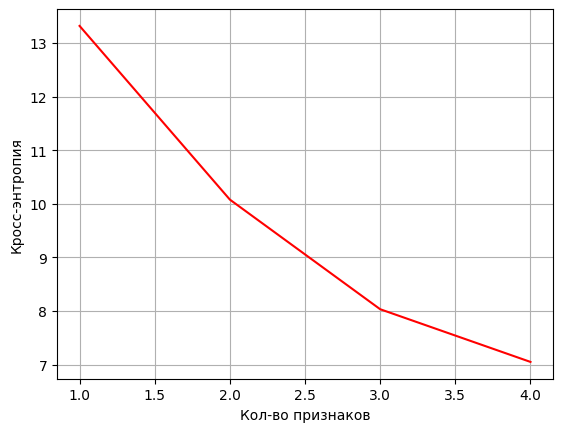

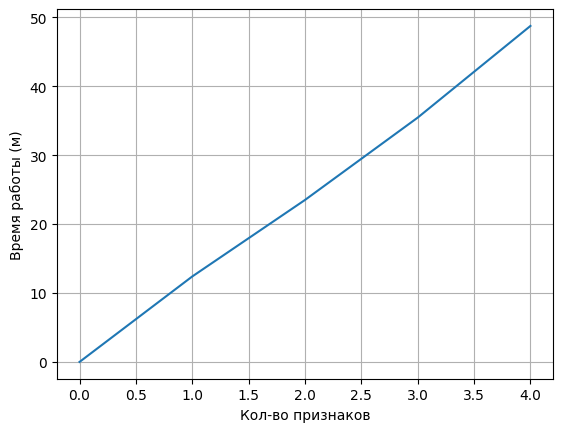

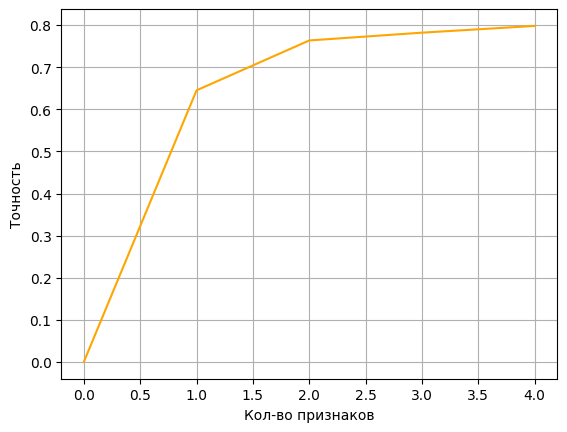

In [ ]:
x = range(1,5)
log_loss = [13.318, 10.078, 8.033,7.05]

plt.plot(x,log_loss,color='red')
plt.grid()
plt.xlabel('Кол-во признаков')
plt.ylabel('Кросс-энтропия')
plt.show()

x = range(0,5)
thetime = [0,12.4, 23.5, 35.45,48.75]
accuracy = [0,0.645, 0.7635, 0.782,0.798]

plt.plot(x,thetime)
plt.grid()
plt.xlabel('Кол-во признаков')
plt.ylabel('Время работы (м)')
plt.show()

plt.plot(x,accuracy,color='orange')
plt.grid()
plt.xlabel('Кол-во признаков')
plt.ylabel('Точность')
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(sfs.transform(data_rescaled),y,test_size=0.25)
knn.fit(X_train, y_train)


predicted_probabilities = cross_val_predict(knn, reduced, y, cv=5, method='predict_proba')

fitness = log_loss(y, predicted_probabilities)
y_pred = knn.predict(X_test)
knn_accuracy = accuracy_score(y_test, y_pred)

print(f'log loss: {fitness}')
print(f'accuracy: {knn_accuracy}')

In [4]:
mat = loadmat('lung_discrete.mat')  # load mat-file

lung_df = pd.DataFrame(np.hstack((mat['X'], mat['Y'])))

col_names = lung_df.columns
col_names = list(map(str,col_names))
col_names[-1] = 'class'
lung_df.columns = col_names
varnames = col_names[:-1]
lung_df

,0,1,2,3,4,5,6,7,8,9,...,316,317,318,319,320,321,322,323,324,class
0,-2,0,2,2,2,-2,-2,0,2,-2,...,0,2,2,0,-2,0,2,2,2,1
1,0,0,-2,2,-2,0,-2,-2,-2,0,...,-2,-2,-2,-2,-2,0,-2,-2,-2,4
2,2,-2,0,2,-2,0,0,-2,0,-2,...,-2,-2,-2,-2,-2,0,-2,-2,-2,4
3,2,2,2,2,2,2,0,0,2,2,...,0,2,2,-2,0,0,0,2,2,7
4,2,2,2,0,0,2,0,0,2,0,...,2,0,2,0,0,2,-2,-2,-2,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0,0,0,2,0,-2,0,0,2,0,...,-2,-2,0,2,0,0,0,2,2,6
69,-2,2,2,0,2,-2,-2,0,-2,2,...,-2,-2,2,0,2,0,2,-2,0,6
70,-2,0,-2,0,0,-2,-2,0,-2,0,...,-2,-2,-2,-2,0,0,0,-2,-2,4
71,2,2,-2,0,-2,-2,2,0,-2,2,...,2,0,0,0,-2,2,-2,0,2,5


In [ ]:
X = lung_df[varnames]
y = lung_df['class']
test_results = [0]
n_neighbors = range(20)
for i in range(1,20):
    knn_accuracy = []
    for j in range(50):
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(X_train, y_train)

        y_pred = knn.predict(X_test)
        knn_accuracy.append(accuracy_score(y_test, y_pred))
    print(i)
    test_results.append(np.average(knn_accuracy))

best n: 3


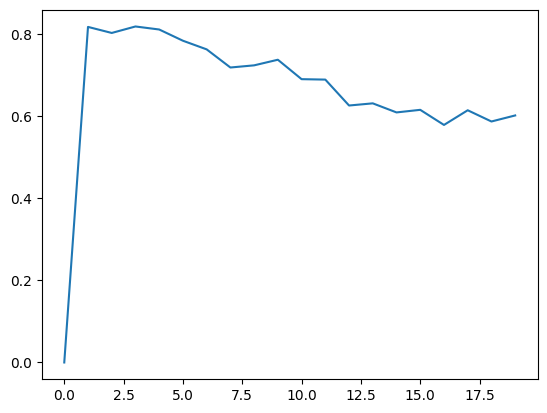

In [ ]:
plt.plot(n_neighbors,test_results)
print(f'best n: {n_neighbors[np.argmax(test_results)]}')

In [7]:
test_size = 1
test_results = np.zeros(test_size)
accur_list = [0.85]
data = []

gene_length = len(varnames)

resulting_features = []
for goal_acc in accur_list:
    for i in range(test_size):
        genetic_object = FSGA(Crossing=FSGA.OnePointCrossover,
                            max_epochs=10,
                            mut_rate=1,
                            population=InitializeFeatSelectPopulation(pop_size=50,n=gene_length),
                            Selection=FSGA.RankingSelection,
                            input_dataset=lung_df,
                            goal_accuracy=goal_acc,
                            select_param=1.9)
        test_results[i], best_result =genetic_object.Fit()
        resulting_features.append(best_result)
    the_bestest_result = resulting_features[np.argmin(test_results)]
    data.append([goal_acc, np.sum(the_bestest_result),np.average(test_results),np.std(test_results), np.min(test_results),np.median(test_results),np.max(test_results)])
    print('*', end = ' ')
df = pd.DataFrame(data, columns=['Целевая точность', 'Количество признаков','МО', 'СКО', 'мин', 'медиана', 'макс'])
df

* 

,Целевая точность,Количество признаков,МО,СКО,мин,медиана,макс
0,0.85,153,2.316677,0.0,2.316677,2.316677,2.316677


In [ ]:

scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(lung_df[varnames])

pca = PCA(n_components= 0.9)
pca.fit(data_rescaled)
reduced = pca.transform(data_rescaled)
y = lung_df['class']

X_train, X_test, y_train, y_test = train_test_split(reduced,y,test_size=0.25)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)


predicted_probabilities = cross_val_predict(knn, reduced, y, cv=5, method='predict_proba')

fitness = log_loss(y, predicted_probabilities)
y_pred = knn.predict(X_test)
knn_accuracy = accuracy_score(y_test, y_pred)

print(f'log loss: {fitness}')
print(f'accuracy: {knn_accuracy}')

log loss: 2.288516709057942
accuracy: 0.3684210526315789


In [ ]:
lung_df

,0,1,2,3,4,5,6,7,8,9,...,316,317,318,319,320,321,322,323,324,class
0,-2,0,2,2,2,-2,-2,0,2,-2,...,0,2,2,0,-2,0,2,2,2,1
1,0,0,-2,2,-2,0,-2,-2,-2,0,...,-2,-2,-2,-2,-2,0,-2,-2,-2,4
2,2,-2,0,2,-2,0,0,-2,0,-2,...,-2,-2,-2,-2,-2,0,-2,-2,-2,4
3,2,2,2,2,2,2,0,0,2,2,...,0,2,2,-2,0,0,0,2,2,7
4,2,2,2,0,0,2,0,0,2,0,...,2,0,2,0,0,2,-2,-2,-2,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0,0,0,2,0,-2,0,0,2,0,...,-2,-2,0,2,0,0,0,2,2,6
69,-2,2,2,0,2,-2,-2,0,-2,2,...,-2,-2,2,0,2,0,2,-2,0,6
70,-2,0,-2,0,0,-2,-2,0,-2,0,...,-2,-2,-2,-2,0,0,0,-2,-2,4
71,2,2,-2,0,-2,-2,2,0,-2,2,...,2,0,0,0,-2,2,-2,0,2,5


In [ ]:
masks = []
glen = len(the_bestest_result)
for i in range(glen):
    if(the_bestest_result[i] == 1):
        masks.append(varnames[i])


best_result_data = lung_df[masks]

X_train, X_test, y_train, y_test = train_test_split(best_result_data,y,test_size=0.25)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)


predicted_probabilities = cross_val_predict(knn, best_result_data, y, cv=5, method='predict_proba')

fitness = log_loss(y, predicted_probabilities)
y_pred = knn.predict(X_test)
knn_accuracy = accuracy_score(y_test, y_pred)

print(f'log loss: {fitness}')
print(f'accuracy: {knn_accuracy}')

log loss: 0.8205519841133051
accuracy: 0.7368421052631579


In [ ]:
lung_df[varnames]

,0,1,2,3,4,5,6,7,8,9,...,315,316,317,318,319,320,321,322,323,324
0,-2,0,2,2,2,-2,-2,0,2,-2,...,-2,0,2,2,0,-2,0,2,2,2
1,0,0,-2,2,-2,0,-2,-2,-2,0,...,-2,-2,-2,-2,-2,-2,0,-2,-2,-2
2,2,-2,0,2,-2,0,0,-2,0,-2,...,-2,-2,-2,-2,-2,-2,0,-2,-2,-2
3,2,2,2,2,2,2,0,0,2,2,...,2,0,2,2,-2,0,0,0,2,2
4,2,2,2,0,0,2,0,0,2,0,...,-2,2,0,2,0,0,2,-2,-2,-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0,0,0,2,0,-2,0,0,2,0,...,2,-2,-2,0,2,0,0,0,2,2
69,-2,2,2,0,2,-2,-2,0,-2,2,...,2,-2,-2,2,0,2,0,2,-2,0
70,-2,0,-2,0,0,-2,-2,0,-2,0,...,-2,-2,-2,-2,-2,0,0,0,-2,-2
71,2,2,-2,0,-2,-2,2,0,-2,2,...,-2,2,0,0,0,-2,2,-2,0,2


In [ ]:

scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(lung_df[varnames])

y = lung_df['class']


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=5)
sfs = SequentialFeatureSelector(knn, n_features_to_select=20)
sfs.fit(data_rescaled, y)

X_train, X_test, y_train, y_test = train_test_split(sfs.transform(data_rescaled),y,test_size=0.25)
knn.fit(X_train, y_train)


predicted_probabilities = cross_val_predict(knn, reduced, y, cv=5, method='predict_proba')

fitness = log_loss(y, predicted_probabilities)
y_pred = knn.predict(X_test)
knn_accuracy = accuracy_score(y_test, y_pred)

print(f'log loss: {fitness}')
print(f'accuracy: {knn_accuracy}')

log loss: 2.288516709057942
accuracy: 0.8947368421052632
